<p class="title">Finite-population SPRT for Population Percentage</p>

## Example of the SPRT without replacement

This notebook develops a sequential probability ratio test for the fraction of items labeled "1" in a population of $N$ items of which $Np$ are labeled $1$ and $N(1-p)$ are labeled "0."

This is a special case of the result derived in the notebook [Wald's Sequential Probability Ratio Test](sprt.ipynb).

There is a population of $N$ items. 
Item $j$ has "value" $a_j \in \{0, 1\}$. 

Define $p = \frac{1}{N}\sum_j a_j$ to be the population percentage.

We want to test the hypothesis $H_0$ that $p = p_0$ against the
alternative hypothesis $H_1$ that $p = p_1 $, for some
fixed $p_1 > p_0$.

We will draw items sequentially, without replacement, such that the chance that item $j$ is selected in draw $i$, assuming it has not been selected already, is $1/(N-j+1)$.
Let ${\mathcal B_{j-1}}$ be the indices of the items selected up to and including the $j-1$st draw,
and ${\mathcal B_0} \equiv \emptyset$. 

Let $\mathbb B_j$ denote the index of the item selected at random in the $j$th draw.

The chance that the first draw ${\mathbb B_1}$ gives an item with value 1, i.e., 
$\Pr \{a_{\mathbb B_1} = 1\}$, is $\frac{1}{N}\sum_b a_b$.
Under $H_0$, this chance is $p_{01} = p_0$; under $H_1$, this chance is 
$p_{11} = p_1$.

Given the values of $\{a_{\mathbb B_k}\}_{k=1}^i$, the conditional
probability that the $i$th draw gives an item with value 1 is

$$
   \Pr \{a_{\mathbb B_i} = 1 | {\mathcal B_{i-1}} \} = \frac{ \sum_{b \notin {\mathcal B_{i-1}}} a_b}{N-i+1}.
$$

Under $H_0$, this chance is

$$
   p_{0i} =  \frac{Np_0 - \sum_{b \in {\mathcal B_{i-1}}} a_b}{N - i + 1}.
$$

Under $H_1$, this chance is

$$
   p_{1i} = \frac{Np_1 - \sum_{b \in {\mathcal B_{i-1}}} a_b}{N - i + 1}.
$$

Let $X_i$ be the indicator of the event that the $i$th draw gives an item with
value $1$, i.e., the indicator of the event $a_{\mathbb B_i} = 1$.
The likelihood ratio for a given sequence $\{X_k\}_{k=1}^i$ is

$$
    \mbox{LR} = \frac{\prod_{k=1}^i p_{1k}^{X_k}(1-p_{1k})^{1-X_k}}
         {\prod_{k=1}^i p_{0k}^{X_k}(1-p_{0k})^{1-X_k}}.
$$

This can be simplified: 
$p_{0k}$ and $p_{1k}$ have the same denominator,
$N - k + 1$, and their numerators share a term.
Define $A(k) \equiv \sum_{b \in {\mathcal B_{k-1}}}$.
Then

$$
    \mbox{LR} = \prod_{k=1}^i 
    \left ( \frac{Np_1 - A(k)}{Np_0 - A(k)} \right )^{X_k}
    \left ( \frac{N(1-p_1) - (k-1-A(k))}{N(1-p_0) - (k-1 - A(k))} \right )^{1-X_k}
$$
$$
   = \left ( \frac{Np_1 - A(k)}{Np_0 - A(k)} \right )^{X_k}
    \left ( \frac{N(1-p_1) - k + 1 + A(k)}{N(1-p_0) - k + 1 + A(k)} \right )^{1-X_k},
$$
where the products are defined to be infinite if any denominator vanishes.

If $H_0$ is true, the chance that $\mbox{LR}$ is ever greater than $1/\alpha$
is at most $\alpha$.


In [8]:
# This is the first cell with code: set up the Python environment
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.random
import scipy as sp
import scipy.stats
# For interactive widgets
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML

In [9]:
np.random.seed(1234567890) # set seed for reproducibility

In [10]:
def LRFromTrials(trials, N, p0, p1):
    '''
       Finds the sequence of likelihood ratios for the hypothesis that the population 
       percentage is p1 to the hypothesis that it is p0, for sampling without replacement
       from a population of size N.
    '''
    A = np.cumsum(np.insert(trials, 0, 0)) # so that cumsum does the right thing
    terms = np.ones(N)
    for k in range(len(trials)):
        if trials[k] == 1.0:
            if (N*p0 - A[k]) > 0:
                terms[k] = np.max([N*p1 - A[k], 0])/(N*p0 - A[k])
            else:
                terms[k] = np.inf
        else:
            if (N*(1-p0) - k + 1 + A[k]) > 0:
                terms[k] = np.max([(N*(1-p1) - k + 1 + A[k]), 0])/(N*(1-p0) - k + 1 + A[k])
            else:
                terms[k] = np.inf
    return(np.cumprod(terms))

<function __main__.plotBernoulliSPRT>

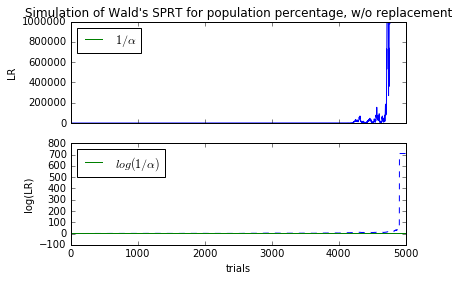

In [11]:
def plotBernoulliSPRT(N, p, p0, p1, alpha):
    '''
       Plots the progress of a one-sided SPRT for N dependent Bernoulli trials 
       in sampling without replacement from a population of size N with a 
       fraction p of items labeled "1," for testing the hypothesis that p=p0 
       against the hypothesis p=p1 at significance level alpha
    '''
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    trials = np.zeros(N)
    nOnes = int(math.floor(N*p))
    trials[0:nOnes] = np.ones(nOnes)
    np.random.shuffle(trials) # items are in random order

    LRs = np.nan_to_num(LRFromTrials(trials, N, p0, p1))
    logLRs = np.nan_to_num(np.log(LRs))
    
    LRs[LRs > 10**6] = 10**6 # avoid plot overflow
    logLRs[logLRs > 10**6] = 10**6 # avoid plot overflow
    
    #
    ax[0].plot(range(N),LRs, color='b')
    ax[0].axhline(y=1/alpha, xmin=0, xmax=N, color='g', label=r'$1/\alpha$')
    ax[0].set_title('Simulation of Wald\'s SPRT for population percentage, w/o replacement')
    ax[0].set_ylabel('LR')
    ax[0].legend(loc='best')
    #
    ax[1].plot(range(N),logLRs, color='b', linestyle='--')
    ax[1].axhline(y=math.log(1/alpha), xmin=0, xmax=N, color='g', label=r'$log(1/\alpha)$')
    ax[1].set_ylabel('log(LR)')
    ax[1].set_xlabel('trials')
    ax[1].legend(loc='best')


interact(plotBernoulliSPRT,\
         N=widgets.IntSlider(min=500, max=50000, step=500, value=5000),\
         p=widgets.FloatSlider(min=0.001, max=1, step=0.01, value=.51),\
         p0=widgets.FloatSlider(min=0.001, max=1, step=0.01, value=.5),\
         p1=widgets.FloatSlider(min=0.001, max=1, step=0.01, value=.51),\
         alpha=widgets.FloatSlider(min=0.001, max=1, step=0.01, value=.05)
        )

## Simulate the distribution of sample sizes needed to reject

In [21]:
alpha = 0.05                   # significance level
reps = int(10**4)              # number of replications
p, p0, p1 = [0.525, 0.5, 0.525]  # need p > p0 or might never reject
N = 10000                       # population size
dist = np.zeros(reps)          # allocate space for the results

trials = np.zeros(N)
nOnes = int(math.floor(N*p))
trials[0:nOnes] = np.ones(nOnes) # trials now contains math.floor(n*p) ones

for i in np.arange(reps):
    np.random.shuffle(trials) # items are in random order
    LRs = LRFromTrials(trials, N, p0, p1) # likelihood ratios for this realization
    dist[i] = np.min(np.where(LRs >= 1/alpha)) # trials at which threshold is crossed

In [22]:
# report mean, median, and 90th percentile
print(np.mean(dist), np.percentile(dist, [50, 90]))

(1788.0844, array([ 1553. ,  3243.2]))


## What's next?

+ [Next: The Kaplan-Wald Confidence Bound for a Nonnegative Mean](kaplanWald.ipynb)
+ [Previous: Wald's Sequential Probability Ratio Test](sprt.ipynb)
+ [Index](index.ipynb)

In [14]:
%run talkTools.py